# Overview

This project implements a Real-Time Fake News Detection system using state-of-the-art Natural Language Processing (NLP) and ensemble Machine Learning (ML) methods. The system classifies news articles as fake or real and can analyze both historical and live news via NewsAPI. It was developed predominantly without the use of advanced AI assistants, emphasizing hands-on expertise in tackling misinformation.

In [44]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split as ts
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix as cm, classification_report as cr
import os
import requests
import json
import pandas as pd
from datetime import datetime
import time

# Dataset

WELFake is a curated dataset of 72,134 news articles (35,028 real / 37,106 fake) made by merging four popular sources, chosen for robust ML training and evaluation.

In [36]:
data = pd.read_csv("/WELFake_Dataset.csv")
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [10]:
data.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [14]:
data.isnull().sum()

,0
Unnamed: 0,0
title,558
text,39
label,0


In [15]:
data.label.value_counts()

,count
label,
1,37106
0,35028


In [37]:
df = data

In [18]:
df.shape

(72134, 4)

In [38]:
df= df.dropna()

In [39]:
df.isnull().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


In [40]:
df.reset_index(inplace=True)
df.head()

,index,Unnamed: 0,title,text,label
0,0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [41]:
df.title[0]

'LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]'

In [42]:
data = df.drop(['Unnamed: 0', 'text'], axis=1)
data.head()

,index,title,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
2,3,"Bobby Jindal, raised Hindu, uses story of Chri...",0
3,4,SATAN 2: Russia unvelis an image of its terrif...,1
4,5,About Time! Christian Group Sues Amazon and SP...,1


# Exploratory Data Analysis

/tmp/ipython-input-3938166456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=data, palette=['#55a868', '#c44e52'])
/tmp/ipython-input-3938166456.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Real News (0)', 'Fake News (1)'])


Class distribution plot saved as class_distribution.png


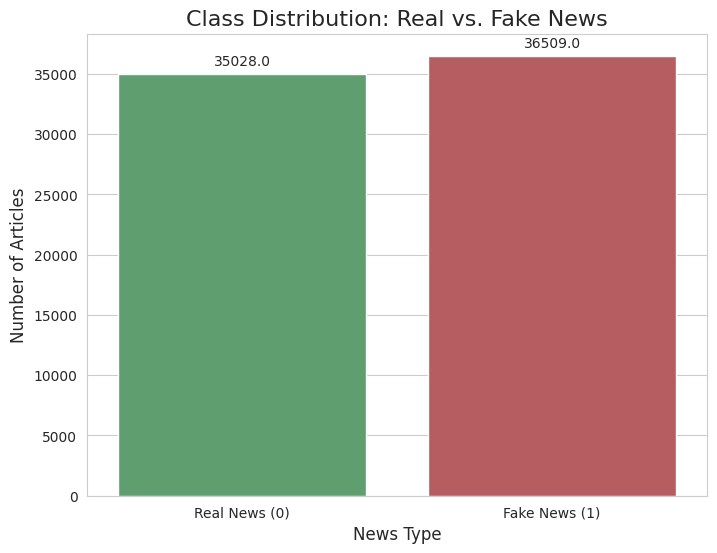

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=data, palette=['#55a868', '#c44e52'])

# Set plot title and labels
plt.title('Class Distribution: Real vs. Fake News', fontsize=16)
plt.xlabel('News Type', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)

# Customize x-tick labels
ax.set_xticklabels(['Real News (0)', 'Fake News (1)'])

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Save the figure
plt.savefig('class_distribution.png')

print("Class distribution plot saved as class_distribution.png")

Title length distribution plot saved as title_length_distribution.png


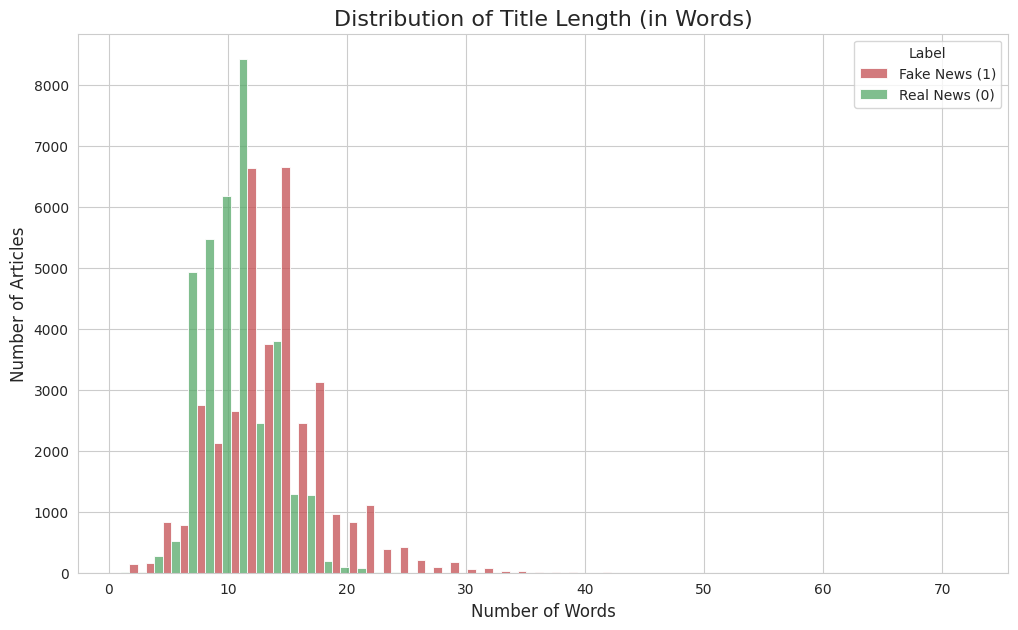

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for the number of words in the title
data['title_word_count'] = data['title'].apply(lambda x: len(str(x).split()))

# Create the plot
plt.figure(figsize=(12, 7))
sns.histplot(data=data, x='title_word_count', hue='label', multiple='dodge', bins=50, palette=['#55a868', '#c44e52'])

# Set plot title and labels
plt.title('Distribution of Title Length (in Words)', fontsize=16)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.legend(title='Label', labels=['Fake News (1)', 'Real News (0)'])


# Save the figure
plt.savefig('title_length_distribution.png')

print("Title length distribution plot saved as title_length_distribution.png")

# Data Preprocessing

1. Tokenization

In [45]:
sample_data = 'The quick brown fox jumps over the lazy dog.'
sample_data = sample_data.split()
sample_data

['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog.']

2. Make Lowercase

In [46]:
sample_data = [data.lower() for data in sample_data]
sample_data

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog.']

3. Remove Stopwords

In [48]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)
print(len(stop_words))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [49]:
sample_data = [data for data in sample_data if data not in stop_words]
print(sample_data)
len(sample_data)

['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog.']


6

4. Stemming

In [50]:
ps = PorterStemmer()
sample_data_stemming = [ps.stem(data) for data in sample_data]
sample_data_stemming

['quick', 'brown', 'fox', 'jump', 'lazi', 'dog.']

5. Lemmatization

In [52]:
nltk.download('wordnet')
lm = WordNetLemmatizer()
sample_data_lemma = [lm.lemmatize(data) for data in sample_data]
sample_data_lemma

[nltk_data] Downloading package wordnet to /root/nltk_data...


['quick', 'brown', 'fox', 'jump', 'lazy', 'dog.']

Implementation of Data-Preprocessing

In [53]:
corpus = []
for i in range(len(data)):
    review = re.sub('^a-zA-Z0-9',' ', data['title'][i])
    review = review.lower() #cpnverts to lowercase
    review = review.split() #toeknize
    review = [lm.lemmatize(x) for x in review if x not in (stopwords.words('english'))] #lemmatize
    review = " ".join(review) #join words back to single string
    corpus.append(review)

In [54]:
len(corpus)

71537

In [56]:
data.title[0]

'LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]'

In [57]:
corpus[0]

'law enforcement high alert following threat cop white 9-11by #blacklivesmatter #fyf911 terrorist [video]'

Successfully created real and fake text corpora.
Word clouds comparison plot saved as word_clouds_comparison.png


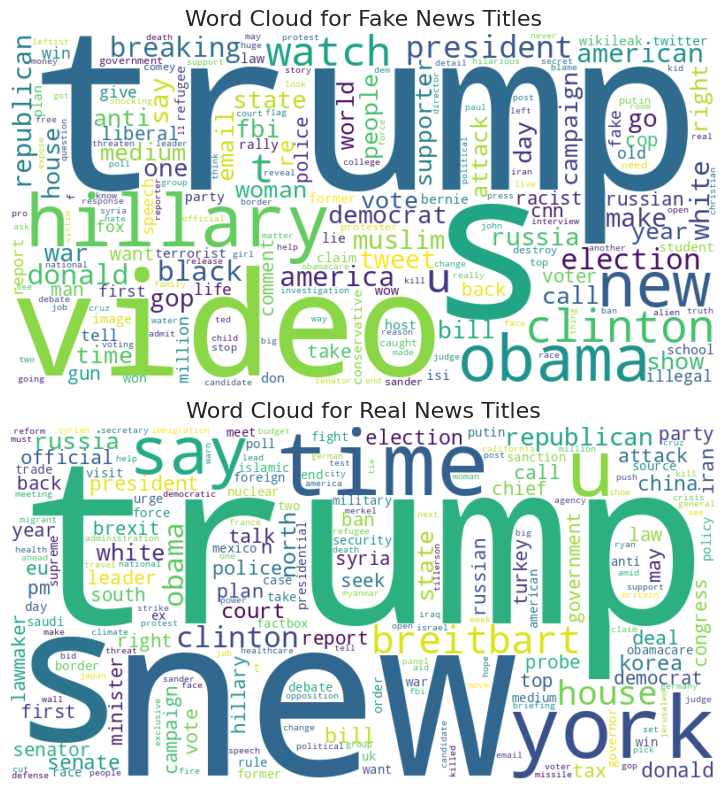

In [73]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

try:
    labels = data['label'].tolist()
    fake_corpus = [corpus[i] for i, label in enumerate(labels) if label == 1]
    real_corpus = [corpus[i] for i, label in enumerate(labels) if label == 0]
    print("Successfully created real and fake text corpora.")
except NameError:
    print("Error: Make sure the 'data' DataFrame and 'corpus' list are defined before running this cell.")


# Join the lists of words into single strings
fake_text = " ".join(fake_corpus)
real_text = " ".join(real_corpus)

# Create WordCloud objects
fake_wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(fake_text)
real_wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(real_text)

# Create the plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot for Fake News
axes[0].imshow(fake_wordcloud, interpolation='bilinear')
axes[0].set_title('Word Cloud for Fake News Titles', fontsize=16)
axes[0].axis('off')

# Plot for Real News
axes[1].imshow(real_wordcloud, interpolation='bilinear')
axes[1].set_title('Word Cloud for Real News Titles', fontsize=16)
axes[1].axis('off')

plt.tight_layout()

# Save the figure
plt.savefig('word_clouds_comparison.png')

print("Word clouds comparison plot saved as word_clouds_comparison.png")

# Vectorization (Convert Text data into the Vector)

In [69]:
tf = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8, ngram_range=(1,2))
x = tf.fit_transform(corpus).toarray()
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
y = data['label']
y.head()

,label
0,1
1,1
2,0
3,1
4,1


# Data splitting into train and test

In [60]:
x_train, x_test, y_train, y_test = ts(x,y,test_size=0.3, random_state = 10, stratify = y)

#dataset is fairly balanced (about 51.4% fake news and 48.6% real news).
#Using stratify=y ensures that both your training and testing sets will also have this approximate 51/49 split

In [61]:
len(x_train), len(y_train)

(50075, 50075)

In [62]:
len(x_test), len(y_test)

(21462, 21462)

# Model Building

Random Forest Classifier

In [74]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

Model Evaluation

In [75]:
y_pred = rf.predict(x_test)
accuracy_score_ = accuracy_score(y_test,y_pred)
accuracy_score_

0.8944180411890784

In [76]:
class Evaluation:

    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def train_evaluation(self):
        y_pred_train = self.model.predict(self.x_train)

        accuracy_score_train = accuracy_score(self.y_train, y_pred_train)
        print("Accuracy score on training data set: ", accuracy_score_train)
        print()

        confusion_matrix_train = cm(self.y_train, y_pred_train)
        print("Confusion matrix on training data set: \n", confusion_matrix_train)
        print()

        classification_report_train = cr(self.y_train, y_pred_train)
        print("Classification report on training data set: \n", classification_report_train)

    def test_evaluation(self):
        y_pred_test = self.model.predict(self.x_test)

        accuracy_score_test = accuracy_score(self.y_test, y_pred_test)
        print("Accuracy score on testing data set: ", accuracy_score_test)
        print()

        confusion_matrix_test = cm(self.y_test, y_pred_test)
        print("Confusion matrix on testing data set: \n", confusion_matrix_test)
        print()

        classification_report_test = cr(self.y_test, y_pred_test)
        print("Classification report on testing data set: \n", classification_report_test)


In [77]:
Evaluation(rf, x_train, x_test, y_train, y_test).train_evaluation()

Accuracy score on training data set:  0.9997403894158762

Confusion matrix on training data set: 
 [[24510     9]
 [    4 25552]]

Classification report on training data set: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     24519
           1       1.00      1.00      1.00     25556

    accuracy                           1.00     50075
   macro avg       1.00      1.00      1.00     50075
weighted avg       1.00      1.00      1.00     50075



In [78]:
Evaluation(rf, x_train, x_test, y_train, y_test).test_evaluation()

Accuracy score on testing data set:  0.8944180411890784

Confusion matrix on testing data set: 
 [[9305 1204]
 [1062 9891]]

Classification report on testing data set: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     10509
           1       0.89      0.90      0.90     10953

    accuracy                           0.89     21462
   macro avg       0.89      0.89      0.89     21462
weighted avg       0.89      0.89      0.89     21462



Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)

# Predict on the test set
y_pred_lr = lr.predict(x_test)

# Evaluate accuracy
accuracy_score_lr = accuracy_score(y_test, y_pred_lr)
accuracy_score_lr

0.8950237629298294

XGB Classifier

In [80]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=10)
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)
print("XGBoost accuracy:", accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:28:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost accuracy: 0.8611499394278259


Classification Report

In [84]:
from sklearn.metrics import classification_report
print(f"classification report of logistic regression{classification_report(y_test, y_pred_lr)}")
print(f"classification report of XGBClassifier{classification_report(y_test, y_pred_lr)}")

classification report of logistic regression              precision    recall  f1-score   support

           0       0.90      0.88      0.89     10509
           1       0.89      0.91      0.90     10953

    accuracy                           0.90     21462
   macro avg       0.90      0.89      0.89     21462
weighted avg       0.90      0.90      0.89     21462

classification report of XGBClassifier /n               precision    recall  f1-score   support

           0       0.90      0.88      0.89     10509
           1       0.89      0.91      0.90     10953

    accuracy                           0.90     21462
   macro avg       0.90      0.89      0.89     21462
weighted avg       0.90      0.90      0.89     21462



# Prediction Pipeline

In [85]:
class Preprocessing:

    def __init__(self,data2):
        self.data2 = data2

    def text_preprocessing_user(self):
        lm = WordNetLemmatizer()
        pred_data = [self.data2]
        preproccess_data = []


        for data2 in pred_data:
            review = re.sub('^a-zA-Z0-9',' ', data2)
            review = review.lower() #converts to lowercase
            review = review.split() #toeknize
            review = [lm.lemmatize(x) for x in review if x not in stopwords.words('english')] #lemmatize
            review = " ".join(review) #join words back to single string
            preproccess_data.append(review)
        return preproccess_data

In [87]:
data2 = data['title'][1]

In [88]:
data2

'UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]'

In [89]:
Preprocessing(data2).text_preprocessing_user()

['unbelievable! obama’s attorney general say charlotte rioter “peaceful” protesters…in home state north carolina [video]']

In [90]:
class Prediction:

    def __init__(self, pred_data, model):
        self.pred_data = pred_data
        self.model = model

    def prediction_model(self):
        preprocess_data = Preprocessing(self.pred_data).text_preprocessing_user()
        data = tf.transform(preprocess_data)
        prediction = self.model.predict(data)

        if prediction [0] == 0:
            return "The News is Fake"
        else:
            return "The News is Real"

In [91]:
data2 = 'UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO]'
Prediction(data2, rf).prediction_model()

'The News is Real'